In [413]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow.keras.backend as K
import joblib
from IPython.display import display
import random


In [414]:
# Tetapkan seed untuk reproduksi
np.random.seed(42)
tf.random.set_seed(42)


In [415]:
# Unduh stopwords untuk Bahasa Indonesia
nltk.download('stopwords')
stopwords_indonesia = stopwords.words('indonesian')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucifrr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [416]:
# Fungsi preprocessing
def preprocess_text(text):
    # Menghapus karakter yang tidak relevan dan menurunkan semua huruf menjadi kecil
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    # Menghapus stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords_indonesia])
    return text


In [417]:
# Memuat dataset JSON untuk NCF
try:
    with open("./dataset.JSON", 'r', encoding='utf-8') as file:
        data = json.load(file)
    print("Dataset berhasil dimuat.")
except Exception as e:
    print(f"Error saat memuat dataset: {e}")
    raise e


Dataset berhasil dimuat.


In [418]:
# Inisialisasi LabelEncoder untuk user dan item
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Kumpulkan semua userIDs dan item titles untuk encoding
all_user_ids = []
all_item_titles = []

for entry in data:
    user_id = entry.get("userID")
    if user_id:
        all_user_ids.append(user_id)
    recommendations = entry.get("recommendation", [])
    for recommendation in recommendations:
        item_title = recommendation.get("title")
        if item_title:
            all_item_titles.append(item_title)

# Encode user IDs dan item titles
user_ids_encoded = user_encoder.fit_transform(all_user_ids)
item_titles_encoded = item_encoder.fit_transform(all_item_titles)
print("User IDs dan Item Titles berhasil di-encode.")


User IDs dan Item Titles berhasil di-encode.


In [419]:
# Membuat mapping itemID ke type
item_types = {}
for entry in data:
    recommendations = entry.get("recommendation", [])
    for rec in recommendations:
        item_title = rec.get("title")
        item_type = rec.get("type")
        if item_title is None or item_type is None:
            print(f"Title atau Type kosong dalam rekomendasi: {rec}")
            continue
        try:
            item_id = item_encoder.transform([item_title])[0]
            if item_id in item_types:
                if item_types[item_id] != item_type:
                    print(f"Item ID {item_id} memiliki tipe yang berbeda: {item_types[item_id]} vs {item_type}")
            else:
                item_types[item_id] = item_type
        except ValueError:
            print(f"Item title '{item_title}' tidak dikenali oleh item_encoder.")
            continue

print(f"Mapping itemID ke type telah dibuat. Contoh: {list(item_types.items())[:5]}")


Item ID 753 memiliki tipe yang berbeda: destinasi vs buku
Mapping itemID ke type telah dibuat. Contoh: [(np.int64(909), 'destinasi'), (np.int64(713), 'destinasi'), (np.int64(365), 'destinasi'), (np.int64(1483), 'destinasi'), (np.int64(122), 'destinasi')]


In [420]:
# Definisikan skala rating maksimum per type
# Pastikan untuk mencakup semua jenis yang ada dalam data
all_types = set(item_types.values())
default_max_rating = 5  # Atur nilai default sesuai kebutuhan

type_max_rating = {item_type: default_max_rating for item_type in all_types}

# Sesuaikan skala rating untuk jenis tertentu
type_max_rating.update({
    'buku': 10,
    'film': 8,
    # Tambahkan penyesuaian lain jika diperlukan
})

print("type_max_rating:", type_max_rating)


type_max_rating: {'buku': 10, 'destinasi': 5, 'film': 8}


In [421]:
# Data Preparation: Assign ratings berdasarkan emosi
print("Mulai memproses data dengan rating berdasarkan emosi dominan.")
processed_data = []

for entry in data:
    user_id = entry.get("userID")
    if not user_id:
        continue  # Lewati entri tanpa userID
    emotions = entry.get("emotionDominant", [])
    recommendations = entry.get("recommendation", [])
    msgEmotion = entry.get("msgEmotion", "")
    for rec in recommendations:
        item_title = rec.get("title")
        item_type = rec.get("type")
        if item_title is None or item_type is None:
            print(f"Title atau Type kosong dalam rekomendasi: {rec}")
            continue
        # Tetapkan rating berdasarkan emosi
        if any(emotion.lower() in ["gembira", "bahagia", "senang"] for emotion in emotions):
            rating = 5
        elif any(emotion.lower() in ["marah", "kesal", "sedih"] for emotion in emotions):
            rating = 2
        else:
            rating = 3  # Netral
        # Pastikan rating adalah numerik
        try:
            rating = float(rating)
        except ValueError:
            print(f"Rating tidak valid untuk item_title {item_title}. Mengabaikan entri ini.")
            continue
        # Encode item title
        try:
            item_id = item_encoder.transform([item_title])[0]
        except ValueError:
            print(f"Item title '{item_title}' tidak dikenali oleh item_encoder.")
            continue
        # Encode user_id
        try:
            user_id_num = user_encoder.transform([user_id])[0]
        except ValueError:
            print(f"User ID '{user_id}' tidak dikenali oleh user_encoder.")
            continue
        # Tambahkan 'type' ke processed_data
        processed_data.append({
            'userID': user_id_num,
            'itemID': item_id,
            'rating': rating,
            'type': item_type  # Tambahkan 'type'
        })

# Cek apakah ada data yang valid
if not processed_data:
    print("Tidak ada data yang diproses dengan rating yang valid.")
    raise ValueError("Dataset tidak memiliki data dengan rating yang valid.")

# Membuat DataFrame
df = pd.DataFrame(processed_data)
print(f"DataFrame dibuat dengan {df.shape[0]} baris.")
print(df.head())


Mulai memproses data dengan rating berdasarkan emosi dominan.
DataFrame dibuat dengan 1709 baris.
   userID  itemID  rating       type
0    1454     909     3.0  destinasi
1     874     713     3.0  destinasi
2     669     365     3.0  destinasi
3     426    1483     3.0  destinasi
4     461     122     3.0  destinasi


Plot distribusi rating berhasil dibuat dan disimpan sebagai 'rating_distribution.png'.


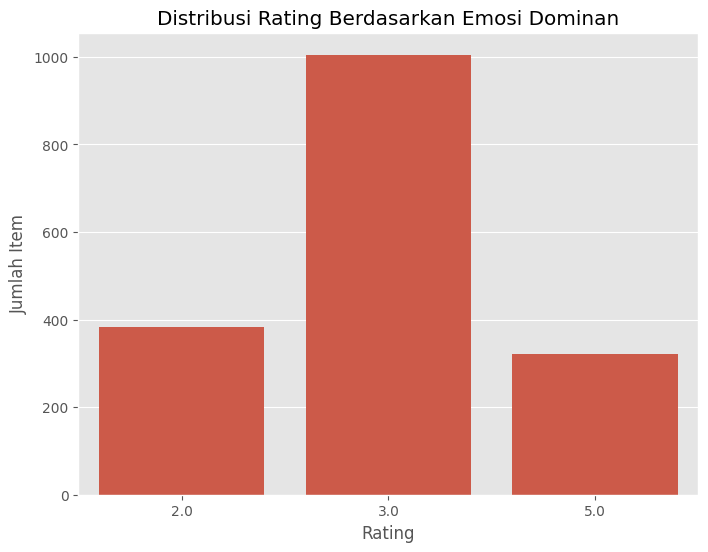

In [422]:
# Visualisasi Distribusi Rating
plt.figure(figsize=(8,6))
sns.countplot(x='rating', data=df)
plt.title('Distribusi Rating Berdasarkan Emosi Dominan')
plt.xlabel('Rating')
plt.ylabel('Jumlah Item')
plt.savefig("rating_distribution.png")
print("Plot distribusi rating berhasil dibuat dan disimpan sebagai 'rating_distribution.png'.")
plt.show()


In [423]:
# Menghitung rating rata-rata per item
df_item_ratings = df.groupby(['itemID', 'type'])['rating'].mean().reset_index()
print("Rating rata-rata per item telah dihitung.")
print(df_item_ratings.head())


Rating rata-rata per item telah dihitung.
   itemID  type  rating
0       0  buku     3.0
1       1  buku     5.0
2       2  buku     5.0
3       3  buku     3.0
4       4  buku     2.0


In [424]:
# Membagi data menjadi train dan test
train, test = train_test_split(df, test_size=0.2, random_state=42)
print(f"Data dibagi menjadi train: {train.shape[0]} dan test: {test.shape[0]}")


Data dibagi menjadi train: 1367 dan test: 342


In [425]:
# Menentukan jumlah pengguna dan item
num_users = df['userID'].nunique()
num_items = df['itemID'].nunique()
print(f"Jumlah pengguna: {num_users}, Jumlah item: {num_items}")


Jumlah pengguna: 1709, Jumlah item: 1698


In [426]:
# Mendefinisikan Metrik Akurasi Kustom
def within_threshold_accuracy(y_true, y_pred, threshold=1.0):
    return K.mean(K.cast(K.abs(y_pred - y_true) <= threshold, 'float32'))


In [427]:
# Membuat model NCF menggunakan Functional API Keras
def build_ncf_model(num_users, num_items, embedding_size=50):
    # Input layers
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')
    
    # Embedding layers
    user_embedding = Embedding(input_dim=num_users + 1, output_dim=embedding_size, name='user_embedding')(user_input)
    item_embedding = Embedding(input_dim=num_items + 1, output_dim=embedding_size, name='item_embedding')(item_input)
    
    # Flatten embeddings
    user_vec = Flatten()(user_embedding)
    item_vec = Flatten()(item_embedding)
    
    # Concatenate user and item vectors
    concat = concatenate([user_vec, item_vec], axis=-1)
    
    # Dense layers
    dense1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(concat)
    dense2 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dense1)
    dense3 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dense2)
    
    # Output layer
    output = Dense(1, activation='linear', name='output')(dense3)
    
    # Create model
    model = Model(inputs=[user_input, item_input], outputs=output)
    
    # Compile model dengan metrik akurasi kustom
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[within_threshold_accuracy]
    )
    
    return model


In [428]:
# Callbacks untuk Early Stopping dan Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    'best_ncf_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [429]:
# Membuat model NCF
embedding_size = 50
model = build_ncf_model(num_users, num_items, embedding_size)
print("Model NCF berhasil dibuat.")
model.summary()


Model NCF berhasil dibuat.


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     85,500 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 50)     │     84,950 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_40          │ (None, 50)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_41          │ (None, 50)        │          0 │ item_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 100)       │          0 │ flatten_40[0][0], │
│ (Concatenate)       │                   │            │ flatten_41[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 256)       │     25,856 │ concatenate_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 128)       │     32,896 │ dense_69[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 64)        │      8,256 │ dense_70[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dense_71[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 237,523 (927.82 KB)

 Trainable params: 237,523 (927.82 KB)

 Non-trainable params: 0 (0.00 B)

In [430]:
# Melatih model NCF
print("Mulai melatih model NCF...")
history = model.fit(
    [train['userID'], train['itemID']],
    train['rating'],
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print("Pelatihan model NCF selesai.")


Mulai melatih model NCF...
Epoch 1/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 11s 679ms/step - loss: 11.3187 - within_threshold_accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 4.22159, saving model to best_ncf_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.9280 - within_threshold_accuracy: 0.0061 - val_loss: 4.2216 - val_within_threshold_accuracy: 0.2667
Epoch 2/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.0074 - within_threshold_accuracy: 0.1562
Epoch 2: val_loss improved from 4.22159 to 1.43673, saving model to best_ncf_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4482 - within_threshold_accuracy: 0.4752 - val_loss: 1.4367 - val_within_threshold_accuracy: 0.5767
Epoch 3/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2127 - within_threshold_accuracy: 0.6719
Epoch 3: val_loss improved from 1.43673 to 1.41194, saving model to best_ncf_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2812 - within_threshold_accuracy: 0.7511 - val

In [431]:
# Evaluasi model
evaluation = model.evaluate([test['userID'], test['itemID']], test['rating'], verbose=0)
print(f"Mean Squared Error (MSE) pada data test: {evaluation[0]:.4f}")
print(f"Akurasi Kustom pada data test: {evaluation[1]*100:.2f}%")


Mean Squared Error (MSE) pada data test: 1.3880
Akurasi Kustom pada data test: 64.28%


In [432]:
# Fungsi untuk plot Training vs Validation Loss dan Accuracy
def plot_training_history(history):
    plt.style.use('ggplot')  # Gaya plot yang lebih menarik
    
    plt.figure(figsize=(14, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['within_threshold_accuracy'], label='Training Accuracy', color='green')
    plt.plot(history.history['val_within_threshold_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("training_validation_loss_accuracy_ncf.png")
    print("Plot Training vs Validation Loss and Accuracy berhasil dibuat dan disimpan sebagai 'training_validation_loss_accuracy_ncf.png'.")
    plt.show()


Plot Training vs Validation Loss and Accuracy berhasil dibuat dan disimpan sebagai 'training_validation_loss_accuracy_ncf.png'.


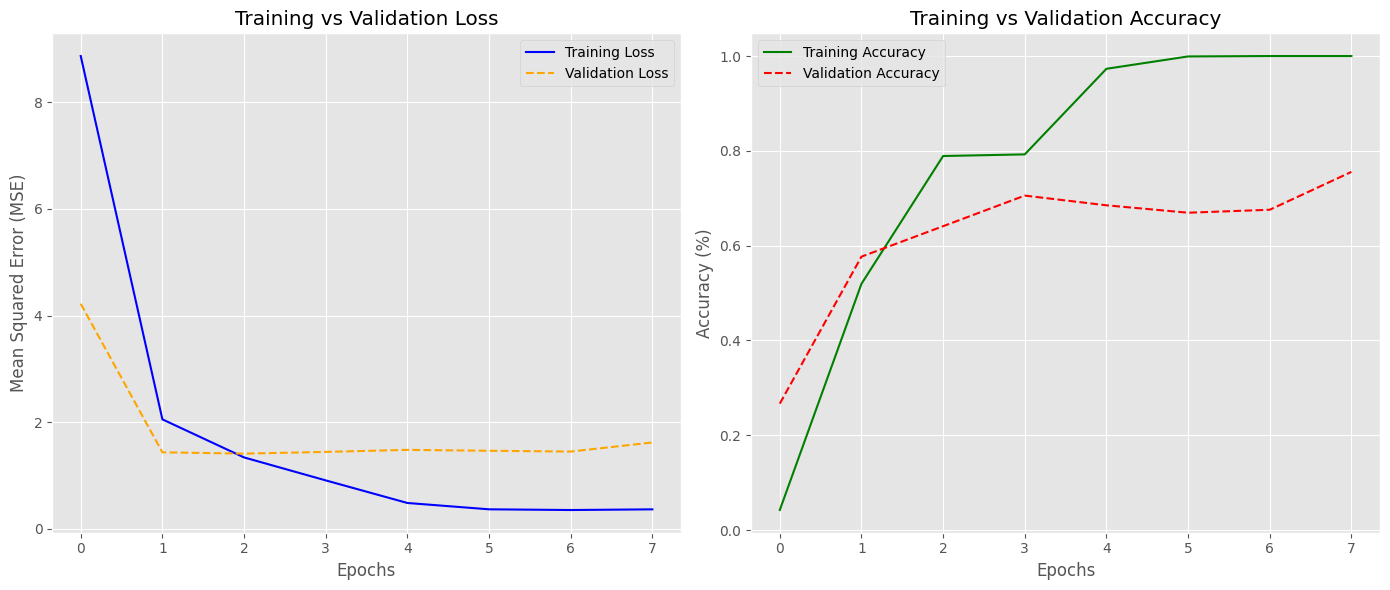

In [433]:
# Membuat grafik Training vs Validation Loss dan Accuracy
plot_training_history(history)


In [434]:
# Menyimpan model dan preprocessing tools
model.save("../../app/models/ncf_model.keras")
joblib.dump(user_encoder, '../../app/models/user_encoder.pkl')  # Menyimpan LabelEncoder untuk user
joblib.dump(item_encoder, '../../app/models/item_encoder.pkl')  # Menyimpan LabelEncoder untuk item
joblib.dump(item_types, '../../app/models/item_types.pkl')      # Menyimpan mapping itemID ke type

print("Model NCF, LabelEncoders, dan Item Types berhasil disimpan!")


Model NCF, LabelEncoders, dan Item Types berhasil disimpan!


In [435]:
# %%
# Fungsi untuk menghasilkan rekomendasi dengan jumlah item 5-10 dan berbagai jenis
def generate_recommendations_ncf_varied(user_emotions, min_n=5, max_n=10):
    """
    Menghasilkan rekomendasi antara min_n dan max_n item dengan berbagai jenis.
    
    Parameters:
    - user_emotions: List emosi dominan pengguna
    - min_n: Jumlah minimal rekomendasi
    - max_n: Jumlah maksimal rekomendasi
    """
    print(f"Memulai rekomendasi dengan emosi dominan: {user_emotions}")
    
    # Tetapkan bobot emosi
    if any(emotion.lower() in ["gembira", "bahagia", "senang"] for emotion in user_emotions):
        # Emosi positif, preferensi tinggi
        rating_multiplier = 1.2
    elif any(emotion.lower() in ["marah", "kesal", "sedih"] for emotion in user_emotions):
        # Emosi negatif, preferensi rendah
        rating_multiplier = 0.8
    else:
        # Emosi netral
        rating_multiplier = 1.0
    
    print(f"Rating multiplier berdasarkan emosi: {rating_multiplier}")
    
    # Cari entri yang cocok dengan emosi dominan
    matching_entries = [
        entry for entry in data 
        if any(emotion.lower() in [e.lower() for e in entry.get("emotionDominant", [])] for emotion in user_emotions)
    ]
    msg_emotions = [entry.get("msgEmotion", "") for entry in matching_entries]
    
    if msg_emotions:
        # Pilih msgEmotion yang paling sering muncul
        msg_emotion = max(set(msg_emotions), key=msg_emotions.count)
    else:
        msg_emotion = "Tidak ada data pengguna. Berikut adalah rekomendasi teratas berdasarkan rating tertinggi dan beberapa rekomendasi acak."
    
    if matching_entries:
        # Pilih pengguna yang pertama kali cocok
        user_id = matching_entries[0].get("userID")
    else:
        # Jika tidak ada pengguna yang cocok, pilih pengguna secara acak
        user_id = random.choice(all_user_ids)
        print("Tidak ada pengguna yang cocok dengan emosi dominan. Menggunakan pengguna secara acak.")
    
    # Encode user_id
    try:
        user_id_num = user_encoder.transform([user_id])[0]
    except ValueError:
        print(f"User ID '{user_id}' tidak dikenali oleh user_encoder.")
        return {
            "msgEmotion": "Emosi tidak dikenali",
            "recommendation": []
        }
    
    print(f"User ID yang dipilih: {user_id} (encoded: {user_id_num})")
    
    # Mendapatkan semua item yang belum pernah diinteraksi oleh user
    user_data = df[df['userID'] == user_id_num]
    interacted_items = user_data['itemID'].values
    all_items = np.arange(num_items)
    items_to_predict = np.setdiff1d(all_items, interacted_items)
    
    print(f"Total item yang akan diprediksi ratingnya: {len(items_to_predict)}")
    
    # Membuat input untuk model
    user_input_array = np.full(len(items_to_predict), user_id_num)
    item_input_array = items_to_predict
    
    # Prediksi rating
    predicted_ratings = model.predict([user_input_array, item_input_array], verbose=0).flatten()
    
    # Membuat DataFrame dengan itemID dan prediksi rating
    predictions_df = pd.DataFrame({
        'itemID': items_to_predict,
        'predicted_rating': predicted_ratings
    })
    
    # Normalisasi prediksi rating berdasarkan type
    predictions_df['type'] = predictions_df['itemID'].map(item_types)
    predictions_df['normalized_predicted_rating'] = predictions_df.apply(
        lambda row: row['predicted_rating'] * rating_multiplier / type_max_rating.get(row['type'], 1),
        axis=1
    )
    
    # Sort berdasarkan normalized_predicted_rating
    predictions_df = predictions_df.sort_values(by='normalized_predicted_rating', ascending=False)
    
    # Randomly choose a number of recommendations between min_n and max_n
    num_recs = random.randint(min_n, max_n)
    print(f"Jumlah rekomendasi yang akan dibuat: {num_recs}")
    
    # Inisialisasi rekomendasi dan jenis yang sudah dipilih
    recommended_items = []
    selected_types = set()
    
    for _, row in predictions_df.iterrows():
        item_id = row['itemID']
        item_type = row['type']
        # Cek apakah jenis ini sudah cukup terwakili
        if item_type not in selected_types:
            try:
                item_title = item_encoder.inverse_transform([int(item_id)])[0]
            except ValueError:
                print(f"Item ID {item_id} tidak dikenali oleh item_encoder.")
                continue
            # Cari detail item dari dataset
            for entry in data:
                for rec in entry.get('recommendation', []):
                    if rec.get("title") == item_title:
                        recommended_items.append({
                            "title": rec.get("title", ""),
                            "image": rec.get("image", ""),
                            "desc": rec.get("desc", ""),
                            "type": rec.get("type", "")
                        })
                        selected_types.add(item_type)
                        print(f"Rekomendasi ditambahkan: {item_title} (type: {item_type})")
                        break
                if len(recommended_items) >= num_recs:
                    break
            if len(recommended_items) >= num_recs:
                break
    
    # Jika belum mencapai jumlah rekomendasi yang diinginkan, tambahkan item berdasarkan rating tanpa memperhatikan jenis
    if len(recommended_items) < num_recs:
        remaining_recs = num_recs - len(recommended_items)
        print(f"Menambahkan {remaining_recs} rekomendasi tambahan berdasarkan rating.")
        for _, row in predictions_df.iterrows():
            item_id = row['itemID']
            item_type = row['type']
            try:
                item_title = item_encoder.inverse_transform([int(item_id)])[0]
            except ValueError:
                continue
            # Cek apakah item sudah direkomendasikan
            if any(rec['title'] == item_title for rec in recommended_items):
                continue
            # Tambahkan item
            for entry in data:
                for rec in entry.get('recommendation', []):
                    if rec.get("title") == item_title:
                        recommended_items.append({
                            "title": rec.get("title", ""),
                            "image": rec.get("image", ""),
                            "desc": rec.get("desc", ""),
                            "type": rec.get("type", "")
                        })
                        print(f"Rekomendasi tambahan ditambahkan: {item_title} (type: {item_type})")
                        break
                if len(recommended_items) >= num_recs:
                    break
            if len(recommended_items) >= num_recs:
                break
    
    print(f"Total rekomendasi yang dikembalikan: {len(recommended_items)}")
    return {
        "msgEmotion": msg_emotion,
        "recommendation": recommended_items[:num_recs]
    }


In [436]:
# Contoh Penggunaan Fungsi generate_recommendations_ncf_diversified
# Misalnya, emosi dominan adalah "Senang", "Bahagia", dan "Terharu"
emotion_input = ["Sedih", "Kesal", "Marah"]
user_recommendations = generate_recommendations_ncf_varied(emotion_input, min_n=5, max_n=5)

# Menampilkan pesan emosi
print("\nPesan Emosi:")
print(user_recommendations["msgEmotion"])

# Display the recommendations in a tabular format menggunakan IPython display
try:
    # Create DataFrame for recommendations
    df_rekom = pd.DataFrame(user_recommendations["recommendation"])[['title', 'image', 'desc', 'type']]
    
    # Display the DataFrame in a tabular format
    display(df_rekom)
except KeyError as e:
    print(f"Kesalahan dalam membuat DataFrame rekomendasi: {e}")
    print("Isi Rekomendasi:", user_recommendations.get("recommendation", []))


Memulai rekomendasi dengan emosi dominan: ['Sedih', 'Kesal', 'Marah']
Rating multiplier berdasarkan emosi: 0.8
User ID yang dipilih: APXU1OXFQEYLWGXDMUJ33X (encoded: 1625)
Total item yang akan diprediksi ratingnya: 1697
Jumlah rekomendasi yang akan dibuat: 5
Rekomendasi ditambahkan: Pantai Patihan (type: destinasi)
Rekomendasi ditambahkan: Badai Pasti Berlalu (type: buku)
Rekomendasi ditambahkan: Badai Pasti Berlalu (type: buku)
Menambahkan 2 rekomendasi tambahan berdasarkan rating.
Rekomendasi tambahan ditambahkan: Pantai Sanglen (type: destinasi)
Rekomendasi tambahan ditambahkan: Tebing Breksi (type: destinasi)
Total rekomendasi yang dikembalikan: 5

Pesan Emosi:
Kamu Ada sesuatu yang mengganggu, membuat hati menjadi kesal. dan Kekhawatiran tentang sesuatu yang belum pasti mengganggu pikiran. dan Ide-ide baru bermunculan, memberi dorongan untuk bergerak maju.


,title,image,desc,type
0,Pantai Patihan,https://picsum.photos/seed/514/200/300,"Pantai ini terletak di daerah Srigading, Sande...",destinasi
1,Badai Pasti Berlalu,https://picsum.photos/seed/802/200/300,The story of a brokenhearted woman who becomes...,buku
2,Badai Pasti Berlalu,https://picsum.photos/seed/815/200/300,"Based on the famous novel, this is a story abo...",buku
3,Pantai Sanglen,https://picsum.photos/seed/759/200/300,Pantai Sanglen. Lokasinya berada di Desa Kemad...,destinasi
4,Tebing Breksi,https://picsum.photos/seed/899/200/300,Tebing Breksi merupakan tempat wisata yang ber...,destinasi


Plot distribusi tipe item dalam rekomendasi berhasil dibuat dan disimpan sebagai 'recommendation_types_distribution_ncf.png'.


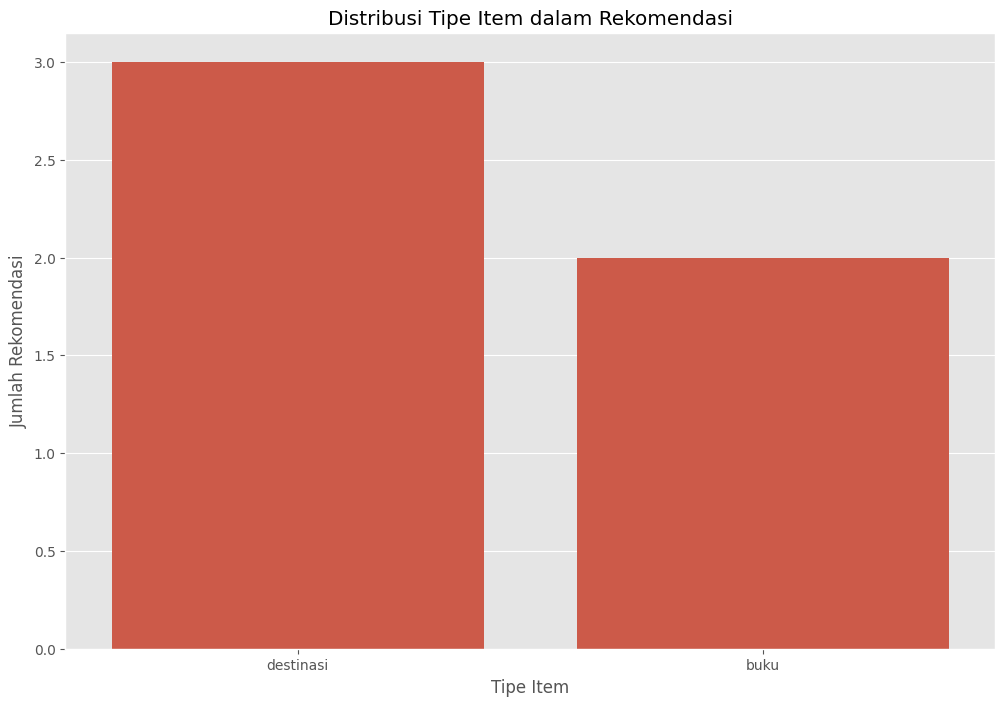

In [437]:
# Visualisasi Rekomendasi
def visualize_recommendations(recommendations):
    plt.figure(figsize=(12, 8))
    types = [item['type'] for item in recommendations]
    sns.countplot(x=types)
    plt.title('Distribusi Tipe Item dalam Rekomendasi')
    plt.xlabel('Tipe Item')
    plt.ylabel('Jumlah Rekomendasi')
    plt.savefig("recommendation_types_distribution_ncf.png")
    print("Plot distribusi tipe item dalam rekomendasi berhasil dibuat dan disimpan sebagai 'recommendation_types_distribution_ncf.png'.")
    plt.show()

visualize_recommendations(user_recommendations["recommendation"])


In [438]:
# Menyimpan rekomendasi ke File JSON
def save_recommendations(recommendations, filename="recommendations_ncf.json"):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(recommendations, f, ensure_ascii=False, indent=4)
    print(f"Rekomendasi berhasil disimpan ke {filename}.")

save_recommendations(user_recommendations)


Rekomendasi berhasil disimpan ke recommendations_ncf.json.


Plot distribusi rating per tipe item berhasil dibuat dan disimpan sebagai 'rating_per_type_ncf.png'.


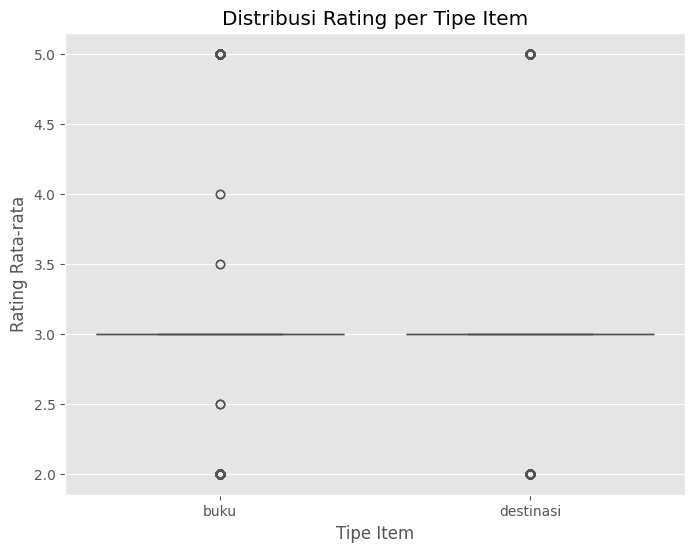

In [439]:
# Analisis Tambahan: Distribusi Rating per Tipe Item
plt.figure(figsize=(8,6))
sns.boxplot(x='type', y='rating', data=df_item_ratings)
plt.title('Distribusi Rating per Tipe Item')
plt.xlabel('Tipe Item')
plt.ylabel('Rating Rata-rata')
plt.savefig("rating_per_type_ncf.png")
print("Plot distribusi rating per tipe item berhasil dibuat dan disimpan sebagai 'rating_per_type_ncf.png'.")
plt.show()
